# Band power monitoring: Site data summary

In [1]:
# This notebook supports input parameters for automatic report generation. The parameters must be variables in this
# cell, which has a special 'parameters' tag.
# DATA_ROOT = r'G:\Shared drives\Covid-19 Spectrum Monitoring\Data'
DATA_ROOT = r'd:\dkuester\covidscratch'

# The values that override these defaults are in ../config.py
HISTOGRAM_RESOLUTION_SWEEPS = 100
HISTOGRAM_POWER_LOW = -100
HISTOGRAM_POWER_HIGH = -11

median_period='20T'

figure_format = 'png'

# report.py will make separate reports for each combination of the below parameters
# that exists in the dataset.
# site = 'd7uzLO-_'

# year = 2020
# month = 7
# day = 1

ccdf_noise_margin_dB = 6

start_date = None
end_date = None

In [6]:
from environment import *
import histogram_analysis as ha
import figures

set_matplotlib_formats(figure_format)

bounds = (HISTOGRAM_POWER_LOW, HISTOGRAM_POWER_HIGH)

shielded_noise_ccdf = ha.read_histogram(
    Path(DATA_ROOT)/'shielded_noise_survival.parquet'
)

site_map = read_dat.read_site_map(DATA_ROOT)

# Source data
hists = ha.read_histogram(
    Path(DATA_ROOT)/'histogram.parquet',
    None,
)

ccdf_kws = dict(
    noise_survival=shielded_noise_ccdf,
    noise_margin_dB=ccdf_noise_margin_dB,
    xlim=bounds,
    figsize=figsize_fullwidth,
    logy=True,
    norm='all',
)

display(HTML(f'This report was produced {time.strftime(time_format)}'))

## Scope of data

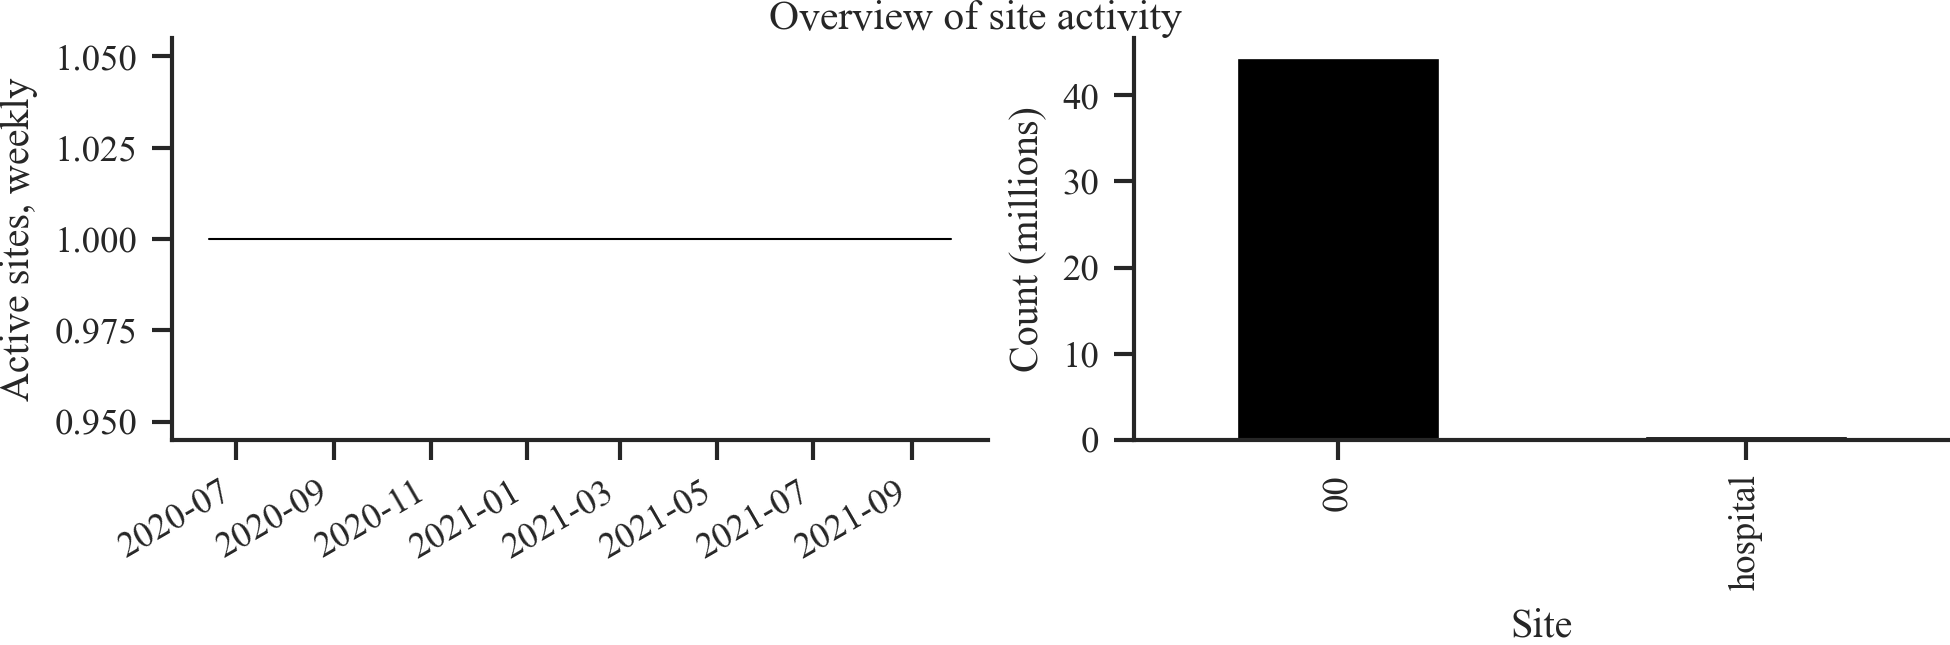

In [7]:
ha = reload(ha)
fig, (ax1, ax2) = subplots(1,2,figsize=figsize_fullwidth)

records = hists.index.to_frame().loc[:,[]].sort_index()
counts_per_week = (
    records
    .groupby(['Site', pd.Grouper(level='Time', freq='1W')])
    .size()/len(hists.index.levels[0])
)
active_sites_per_week = (counts_per_week>0).groupby('Time').size()

active_sites_per_week.plot(ax=ax1, color='black')
ax1.set_ylabel('Active sites, weekly')
ax1.set_xlabel('')

(
    records
    .groupby('Site')
    .size()
    .reindex(list(records.index.levels[1]), fill_value=0)
    *12*105/1e6
).plot.bar(ax=ax2, logy=False, color='black')
ax2.set_ylabel('Count (millions)')
# figures.subplot_title(ax2, f'Band power measurements per site ({start_date or ""}-{end_date or ""})')
fig.suptitle(f'Overview of site activity')

set_caption(fig, f'Distribution of available data by time and site, {ha.date_bounds(hists)}.')

### LTE Uplink Bands

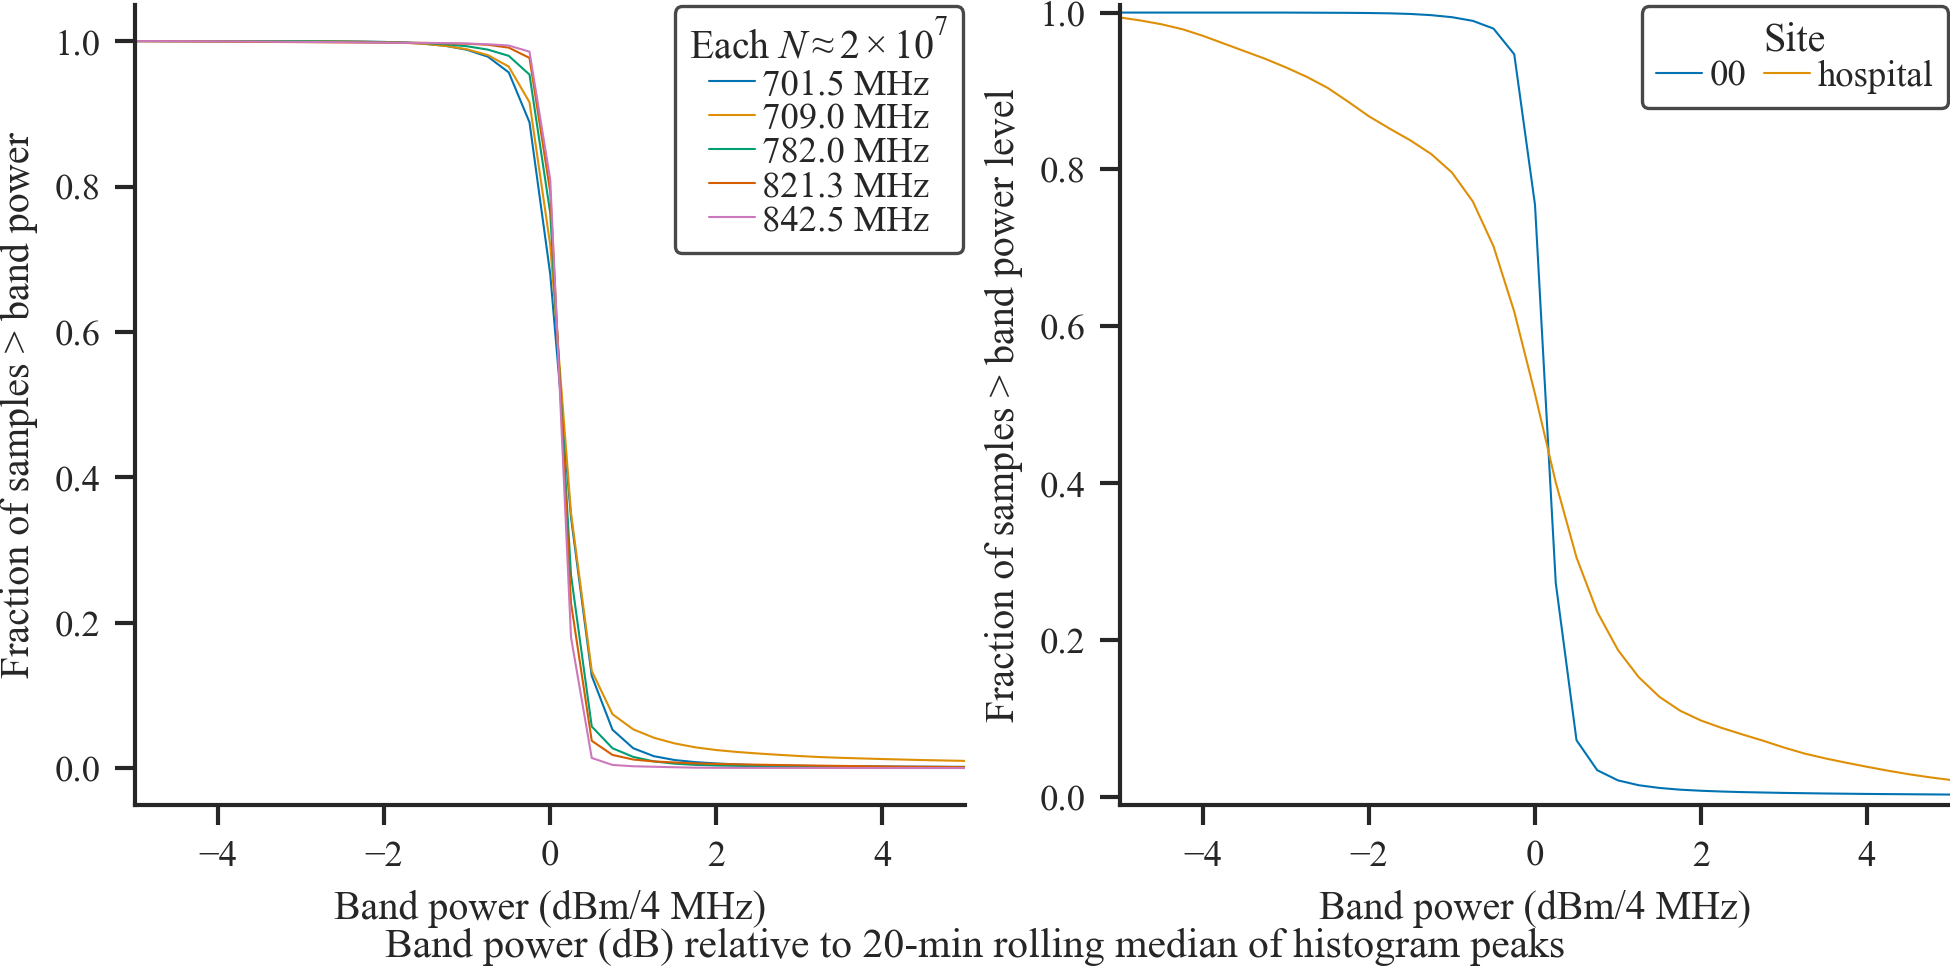

In [8]:
figures = reload(figures)
fc_list = fc_lte_ul
group_name=f'LTE uplink bands'
group_hists = ha.loc_by_fc_spec(hists, fc_list)

# Special for LTE uplink: Survival functions of power normalized by dwell
h_normed_rcum, dwell_norm = ha.rcumsum_on_dwell_norm(group_hists, median_period, dwell_stat='median')

fig, (ax1, ax2) = subplots(1,2,figsize=(figsize_fullwidth[0], 1.5*figsize_fullwidth[1]))
figures.plot_survival_each_frequency(h_normed_rcum, **dict(ccdf_kws, xlim=[-5,5], logy=False, ax=ax1))
figures.plot_survival_each_site(h_normed_rcum, **dict(ccdf_kws, xlim=[-5,5], logy=False, ax=ax2))

fig.suptitle(f'{group_name} relative to interference', visible=False)
fig.supxlabel(f'Band power (dB) relative to 20-min rolling median of histogram peaks')
set_caption(
    fig,
    f"""Empirical CCDF of band power in {group_name} relative to the interference floor, by frequency (left) and site (right). """
    f"""On the left, counts were summed from all sites, and on the right, counts were summed across all center frequencies in the band. """
    f"""{ha.date_bounds(hists)}."""
)

# # Survival functions of power
# h_rcum = ha.rcumsum(group_hists)

# ax = figures.plot_ccdf_each_frequency(h_rcum, title=group_name, **dict(ccdf_kws, norm='site'));
# # ax = figures.plot_ccdf_each_frequency(h_rcum, title=group_name, **dict(ccdf_kws, logy=False));

# ax = figures.plot_ccdf_each_site(h_rcum, title=group_name, **dict(ccdf_kws));
# # ax = figures.plot_ccdf_each_site(h_rcum, title=group_name, **dict(ccdf_kws, logy=False));

AttributeError: module 'figures' has no attribute 'plot_ccdf_each_frequency'

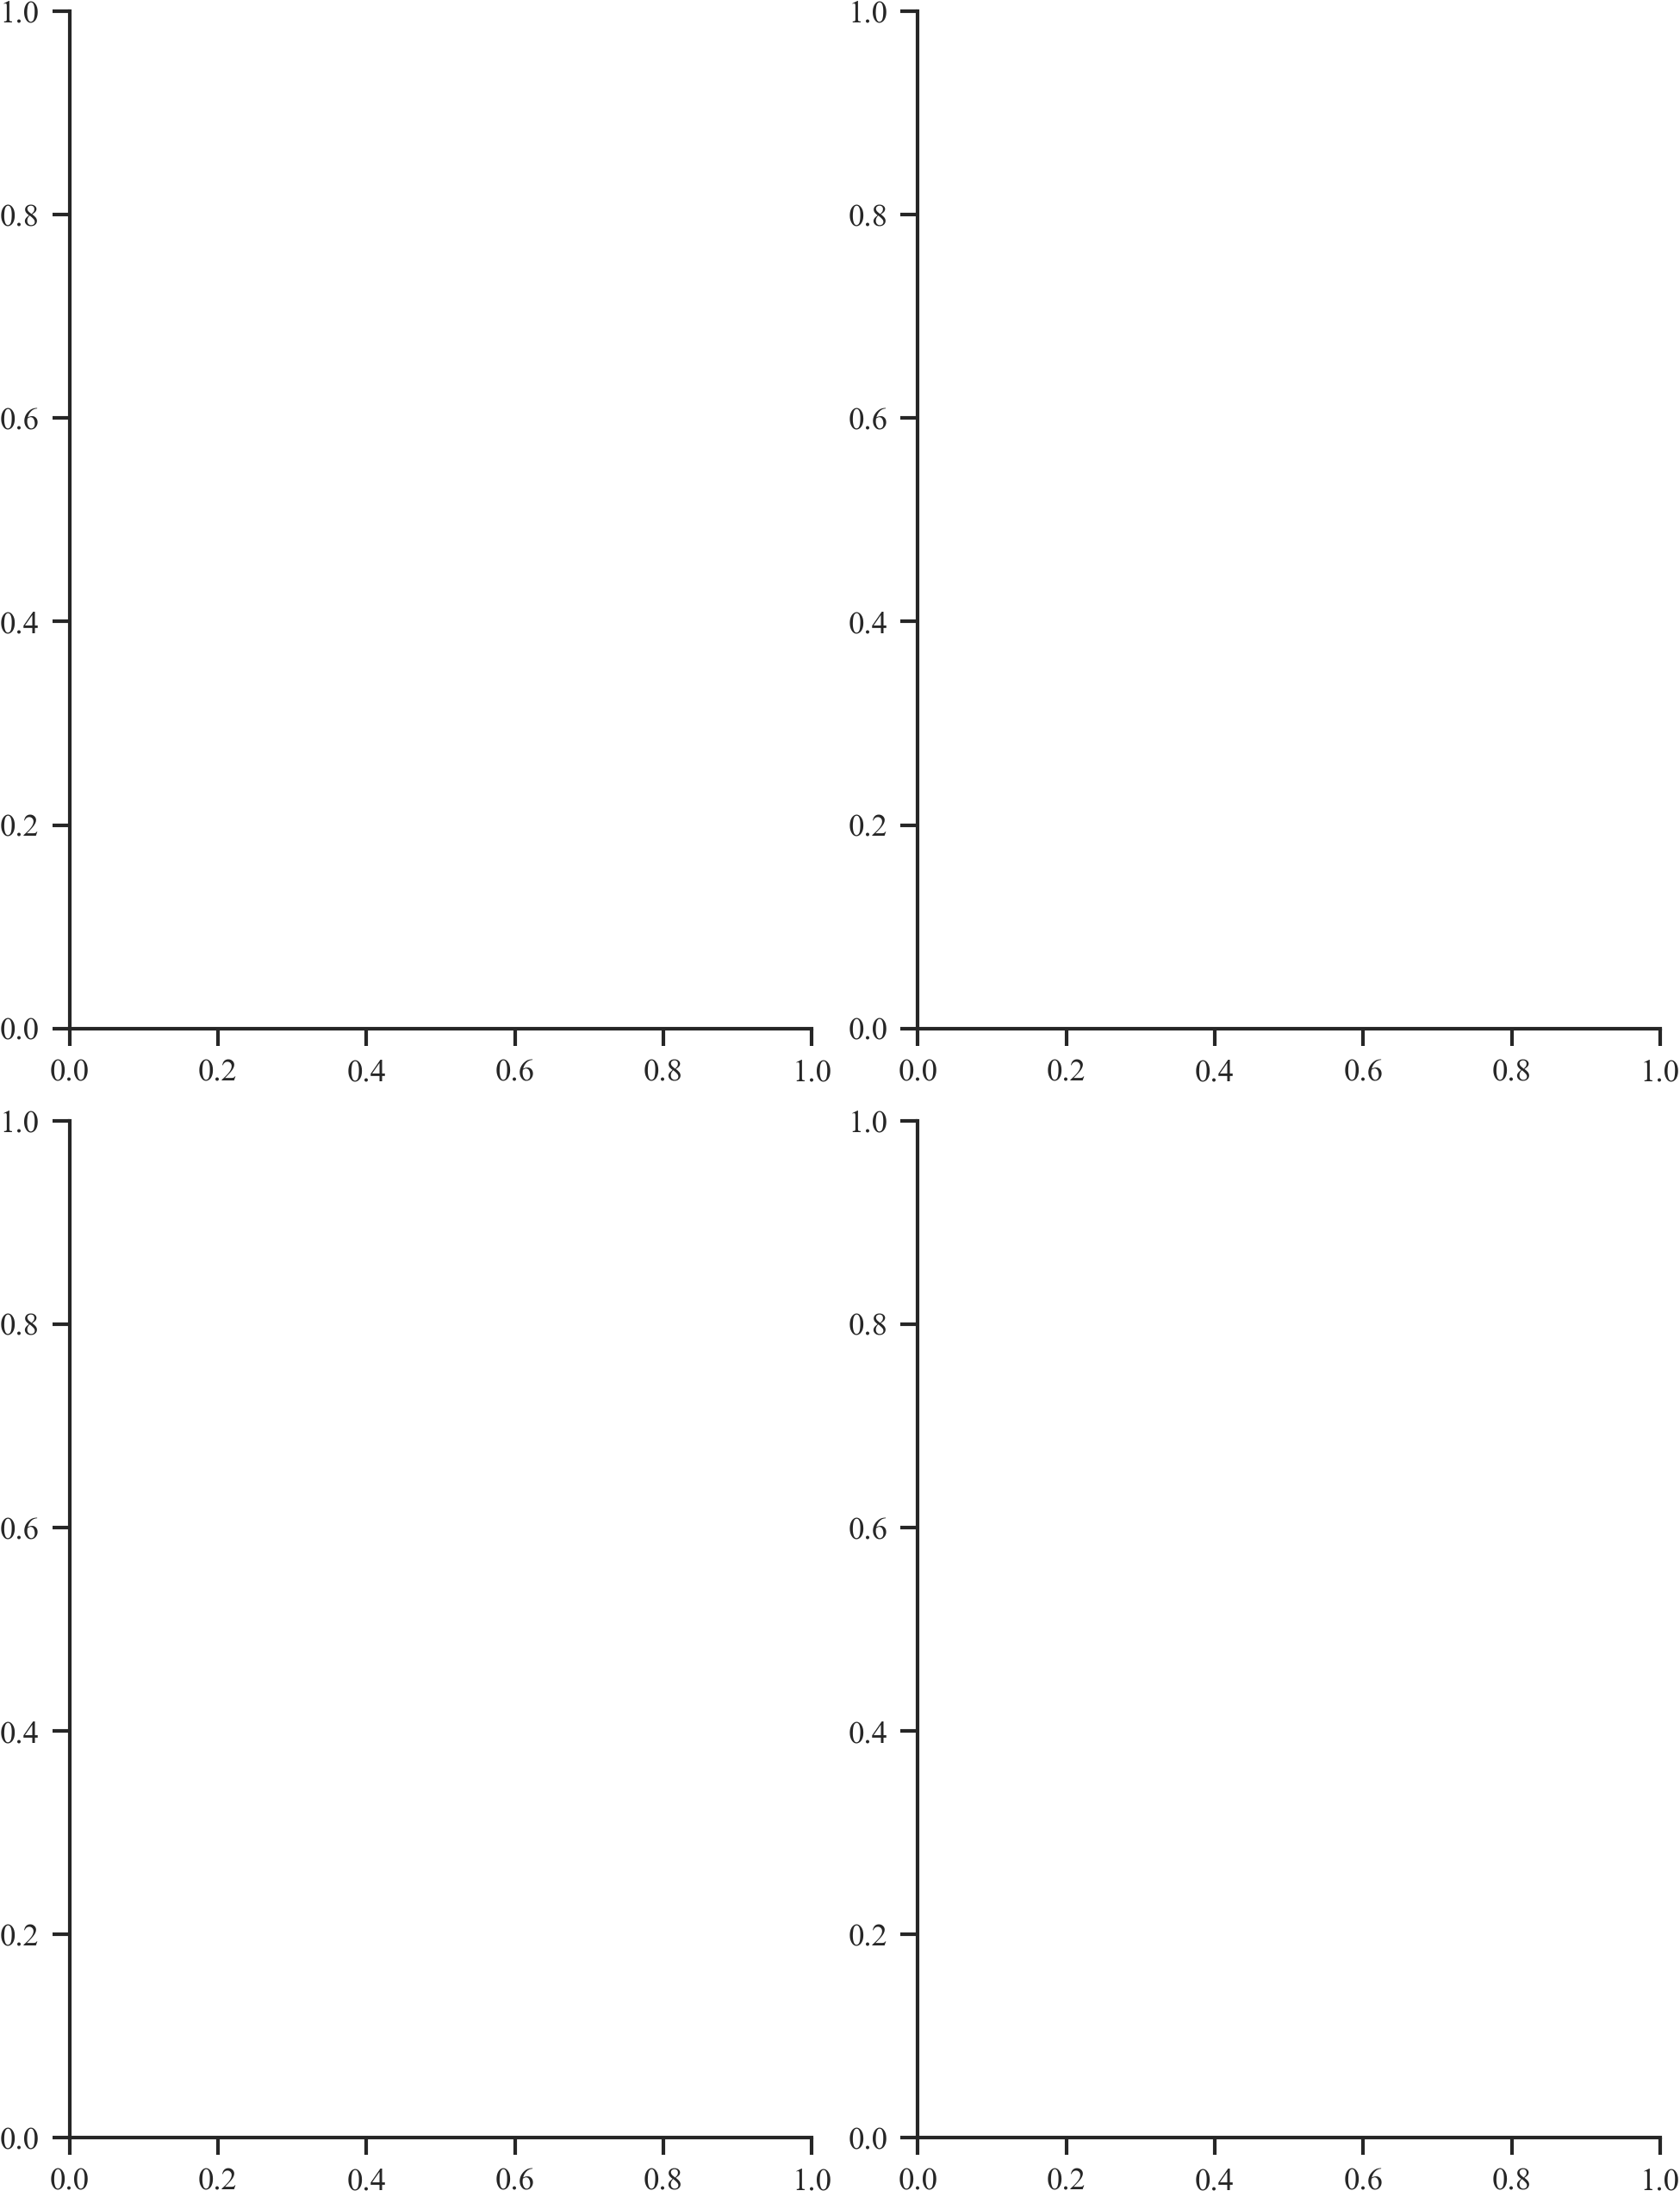

In [9]:
figures = reload(figures)

fig, axs = subplots(2,2, figsize=(figsize_fullwidth[0], 8.5))
axs = list(axs[0])+list(axs[1])


for (group_name, fc_list), ax in zip(FC_NAMED.items(), axs):
    kws = dict(
        ccdf_kws,
        norm='site',
        ax=ax,
        xlim=(-81,-11)
    )

    figures.plot_survival_each_frequency(
        ha.rcumsum(ha.loc_by_fc_spec(hists, fc_list)),
        title=group_name,
        **kws
    );

    ax.set_title('', visible=False)

    ax.yaxis.get_label().set_visible(False)
    ax.xaxis.get_label().set_visible(False)

fig.supxlabel(figures.power_label)
fig.supylabel('Fraction of samples > band power level, averaged per site')
fig.suptitle('Empirical SFs averaged by site', visible=False)
set_caption(
    fig,
    """Mean of each site's empirical CCDFs of band power, categorized by center frequency. """
    """This averaging illustrates the stress on recevers' dynamic range experienced in these environments. """
    """To illustrate rare events, the traces are transformed onto a logarithmic vertical axis."""
)

In [ ]:
figures = reload(figures)

fig, axs = subplots(2,2, figsize=(figsize_fullwidth[0], 8.5))
axs = list(axs[0])+list(axs[1])

for (group_name, fc_list), ax in zip(FC_NAMED.items(), axs):
    kws = dict(
        ccdf_kws,
        norm='site',
        ax=ax,
        logy=False,
        xlim=(-81,-11)
    )

    figures.plot_survival_each_frequency(
        ha.rcumsum(ha.loc_by_fc_spec(hists, fc_list)),
        title=group_name,
        **kws
    );

    ax.set_title('', visible=False)

    ax.yaxis.get_label().set_visible(False)
    ax.xaxis.get_label().set_visible(False)

axs[-1].set_ylim([0,.05])

fig.supxlabel(figures.power_label)
fig.supylabel('Fraction of samples > band power level, averaged per site')
fig.suptitle('Empirical SFs averaged by site', visible=False)
set_caption(
    fig,
    """Mean of each site's empirical CCDFs of band power, categorized by center frequency. """
    """This averaging illustrates the stress on recevers' dynamic range experienced in these environments. """
    """To emphasize the most frequently sampled values of band power, the vertical axis is on a linear scale."""
)

In [ ]:
figures = reload(figures)

fig, axs = subplots(2,2, figsize=(figsize_fullwidth[0], 8.5))
axs = list(axs[0])+list(axs[1])

for (group_name, fc_list), ax in zip(FC_NAMED.items(), axs):
    kws = dict(
        ccdf_kws,
        norm='all',
        ax=ax,
        xlim=(-81,-11)
    )

    figures.plot_survival_each_site(
        ha.rcumsum(ha.loc_by_fc_spec(hists, fc_list)),
        title=group_name,
        **kws
    );

    ax.yaxis.get_label().set_visible(False)
    ax.xaxis.get_label().set_visible(False)
    ax.set_title(group_name, visible=True)

    if ax != axs[1]:
        ax.get_legend().set_visible(False)

fig.supxlabel(figures.power_label)
fig.supylabel('Fraction of samples > band power level')
fig.suptitle('Empirical SFs averaged by site', visible=False)
set_caption(
    fig,
    """Empirical CCDFs of band power per site, categorized by band activity. """
    """To illustrate rare events, the traces are transformed onto a logarithmic vertical axis."""
)



In [ ]:
figures = reload(figures)

fig, axs = subplots(2,2, figsize=(figsize_fullwidth[0], 8.5))
axs = list(axs[0])+list(axs[1])

for (group_name, fc_list), ax in zip(FC_NAMED.items(), axs):
    kws = dict(
        ccdf_kws,
        norm='all',
        ax=ax,
        xlim=(-81,-11),
        logy=False
    )

    figures.plot_survival_each_site(
        ha.rcumsum(ha.loc_by_fc_spec(hists, fc_list)),
        title=group_name,
        **kws
    );

    ax.yaxis.get_label().set_visible(False)
    ax.xaxis.get_label().set_visible(False)
    ax.set_title(group_name, visible=True)

    if ax != axs[1]:
        ax.get_legend().set_visible(False)

axs[-1].set_ylim([0,.05])

fig.supxlabel(figures.power_label)
fig.supylabel('Fraction of samples > band power level')
fig.suptitle('Empirical SFs averaged by site', visible=False)
set_caption(
    fig,
    """Empirical CCDFs of band power per site, categorized by band type. """
    """To emphasize the most frequently sampled values of band power, the vertical axis is on a linear scale."""
)

### LTE Downlink Bands

In [ ]:
figures = reload(figures)
fc_list = fc_lte_dl
group_name=f'LTE downlink bands'
group_hists = ha.loc_by_fc_spec(hists, fc_list)

figures.plot_heatmap_relative_to_daily_median(group_hists, fc_list)

### 2695 MHZ Quiet Band

In [ ]:
figures = reload(figures)

fc_list = [fc_quiet]
group_hists = hists.loc[fc_list]
h_fc = group_hists.reset_index('Frequency', drop=True)

daily_mean = ha.compute_dwell_median(
    h_fc,
    rolling_stat_period='1D',
    rolling_stat_name='median',
    by=['Site']
)

h_tod = (
    ha.rebin_time_scale(h_fc, '10T')
    .groupby('Time')
    .sum()
)

fig, ax = subplots(figsize=[figsize_fullwidth[0],3.75])

figures.plot_power_histogram_heatmap(
    h_tod,
    bounds=(-110,-40),
    ax=ax,
    title=None
)
xlabel('Time of day (local time)')

fig.suptitle(f'Histogram heat map by time of day, 2695 MHz', visible=False)

set_caption(
    fig,
    f"""
    Histogram heat map of all band power samples in the passive services band at 2695 MHz, summed across all sites by time of day with bin size 10 minutes.
    Spurious high power samples (around 1 part in $3 \times 10^6$) were acquired mostly during daylight and early evening hours.
    """
)

fig, ax = subplots(figsize=[figsize_fullwidth[0],3.75])

figures.plot_power_histogram_heatmap(
    h_fc.reset_index('Site', drop=True).sort_index().resample('1D').sum(),
    bounds=(-110,-40),
    ax=ax,
    title=None
)

fig.suptitle(f'Histogram heat map by date, 2695 MHz', visible=False)

set_caption(
    fig,
    f"""
    Histogram heat map of all band power samples in the passive services band at 2695 MHz, summed across all sites on each calendar day.
    Spurious high readings (around 1 part in $10^6$) were acquired mostly in September through November of 2020.
    """
)

# figures.plot_counts_each_frequency(
#     group_hists,
#     fc_list=fc_list,
#     title=None,
#     xlim=(-110,-40),
#     logy=False,
#     ax=ax1
# );
# ax1.get_legend().set_visible(False)
# fig.suptitle(f'Histograms of band power, {group_title}, all sites')
# set_caption(
#     fig,
#     f"""Histograms of band power samples in all sites at {group_title}, in bulk (left) and distributed
#     by time of day (right).
#     """
# )

h_rcum = ha.rcumsum(group_hists)

fig, (ax1, ax2) = subplots(1,2,figsize=[figsize_fullwidth[0],3.75])

figures.plot_survival_each_frequency(
    h_rcum,
    # noise_ccdf=shielded_noise_ccdf,
    # noise_margin_dB=ccdf_noise_margin_dB,
    xlim=(-100,-40),
    norm='all',
    logy=True,
    ax=ax1
);

figures.plot_survival_each_site(
    h_rcum,
    # noise_ccdf=shielded_noise_ccdf,
    # noise_margin_dB=ccdf_noise_margin_dB,
    xlim=(-100,-40),
    norm=False,
    logy=True,
    ax=ax2
);
ax2.legend(title='Site')

ax1.get_legend().set_visible(False)

fig.suptitle(f'Empirical SF quiet bands', visible=False)

set_caption(
    fig,
    f"""Empirical CCDFs of band power in the passive services band at 2695 MHz, both across all sites (left) and categorized by site (right). To illustrate rare events,
    plots average of the SF from each site (left) are shown on a logarithmic vertical axis. 
    The SF of all samples received, shown with linear scale (right), emphasizes the most frequenct power levels. Dotted lines
    indicate expected distortion of the power level by 1\,dB due to noise or compression inside the sensor.
    """
)

In [ ]:
ha = reload(ha)
import environment
environment = reload(environment)
sites = hists.index.levels[hists.index.names.index('Site')]

fig, ax = subplots(figsize=figsize_fullwidth)

for name, h_noise in hists.loc[fc_quiet].groupby('Site'):
    ax = (
        h_noise
        .reset_index('Site', drop=True)
        .resample('3H', level='Time') # leads to NaNs that
        .sum()
        .pipe(ha.compute_dwell_mean, accept_quantile=.5, rolling_stat_period='60T', rolling_stat_name='mean', by=None)
        .replace(h_noise.columns[1], np.nan)
        .plot(label=name, ax=ax, lw=0.25)
    )
ylim([-90, -83])
ax.legend(title='Site', ncol=1, columnspacing=0.5, handlelength=1.25)
ax.set_title(f'Band power average at 2695 MHz')
ax.set_ylabel(figures.power_label)
ax.xaxis.get_label().set_visible(False)
xlim(['2020-06-01','2021-10-31']);
set_caption(
    fig,
    f"""Long-term stability in band power sensed at 2695 MHz. To improve clarity on this time scale, averaging was applied to reduce variance. The mean was computed on the """
    f"""center 2 quartiles of each dwell window samples, and the traces are a 1 hour moving mean of this dwell average. The result here encapsulates the full """
    f"""data set, categorized by site. """
)

## Survival functions by frequency group

In [ ]:
# # remap frequency histograms into group histograms
# ha = reload(ha)

# group_mapping = dict(
#     [(fc_map[fc], 'LTE uplink') for fc in fc_lte_ul]+
#     [(fc_map[fc], 'LTE downlink') for fc in fc_lte_dl]+
#     [(fc_map[fc], 'ISM') for fc in fc_ism]+
#     [(fc_map[fc], 'Quiet') for fc in [fc_quiet]]+
#     [(fc_map[fc], 'U-NII') for fc in fc_unii]
# )

# hist_agg = hists.groupby([group_mapping, 'Site'], level=['Frequency', 'Site'], sort=False).sum()

# # hist_normed_agg = aggregate_hist_by_frequency_group(hists_normed_total)
# # hist_normed_agg.plot(logy=True, rasterized=True)
# # xlabel(f'Power above median (dB)')
# # ylabel(f'Fraction of power aperture samples in bands');
# # xlim([-60,+70])

# # hist_agg = aggregate_hist_by_frequency_group(hists.groupby(['Frequency','Site'], sort=False).sum());

# fig, (ax1, ax2) = subplots(1,2,figsize=figsize_fullwidth)

# (
#     hist_agg
#     .groupby('Frequency')
#     .sum()
#     .T
#     .divide(1e6)
#     .plot(logy=False, rasterized=True,ax=ax1,legend=False)
# )
# ax1.set_xlabel(figures.power_label);
# ax1.set_ylabel(f'Sample count (millions)');
# ax1.set_xlim(bounds);

# # h_rcum_agg = hist_agg.iloc[::-1].cumsum().iloc[::-1].astype('float')
# # h_rcum_agg.values[:] = h_rcum_agg.values[:]/h_rcum_agg.values[0,:][np.newaxis,:]

# (
#     hist_agg
#     .groupby('Frequency').sum()
#     .pipe(ha.rcumsum)
#     .T
#     .pipe(ha.normalize_by_first_row)
#     .plot(logy=True, rasterized=True,ax=ax2,legend=False)
# )
# # # h_rcum_agg.values[:] = h_rcum_agg.values[:]/h_rcum_agg.values[0,:][np.newaxis,:]
# # h_rcum_agg.plot(logy=True, rasterized=True);
# ax2.set_xlabel(figures.power_label);
# ax2.set_ylabel(f'Fraction of samples > band power level');
# ax2.set_xlim(bounds);
# figlegend(hist_agg.index.levels[0])

# fig.suptitle(f'Empirical distributions by band type, {date_span}')
# set_caption(
#     fig,
#     f"""Empirical histograms (left) and CCDFs (right) of all samples received
#     in each type of band under test.
#     """
# )

In [ ]:
# for band_type in np.unique(list(group_mapping.values())):
#     fig, ax = subplots(figsize=figsize_fullwidth) 
#     (
#         hist_agg
#         .loc[band_type]
#         .groupby('Site').sum()            # Sum time and frequency counts for each site
#         .pipe(ha.rcumsum) # -> unnormalized empirical CDF
#         .T
#         .pipe(ha.normalize_by_first_row)
#         .plot(logy=True, rasterized=True, ax=ax, title=f'Empirical band power SFs by site, all {band_type} bands, {date_span}')
#     )
#     ax.set_xlim(bounds);
#     ax.set_xlabel(figures.power_label)
#     ax.set_ylabel(f'Fraction of samples > band power level')
#     ax.legend(ncol=3, title='Site')

#     set_caption(
#         fig,
#         f"""
#         Comparison of empirical surival functions in {band_type} bands in the test sites across all {date_span}.
#         """
#     )
